# CSCA 5622 Final Project - DOROTHEA Dataset Supervised Learning Model

#### The DOROTHEA dataset (downloaded from UCI https://archive.ics.uci.edu/dataset/169/dorothea) contains data used for drug discovery. As possible drugs are considered, the most important consideration is if they bind to the desired receptor or not. This dataset maps potential drug substances to active (+1) or inactive (-1) depending on their binding activity to the desired receptor.

##### This dataset is altered to include randomly placed probe features with no predictive power as a means to test feature selection, so this project will emphasize feature selection as a main part of the data cleaning. There are 100,000 features, half of which are real, half are probes. The training set includes 800 observations, the validation set includes 350 observations.

##### The dataset is described as a sparse binary dataset, meaning that there are few observations that are recorded as True for each feature. Each observation is a different small molecule drug, and the features describe their structure. The structure is used to infer whether or not the molecule will bind to the target receptor, which would determine if the molecule would work as a drug for that specific disease. The structural information can then be used to either design new molecules that would bind to the receptor and that have other desirable qualities, which would vary depending on the drug.

In [112]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve

In [24]:
train_data_native = pd.read_csv('dorothea_train.csv', header = None)
train_labels = pd.read_csv('dorothea_train_labels.csv', header = None)
train_labels = np.ravel(train_labels)
test_data_native = pd.read_csv('dorothea_test.csv', header = None)
test_labels = pd.read_csv('dorothea_test_labels.csv', header = None)
test_labels = np.ravel(test_labels)
print(train_data_native.head())
print(train_labels[:10])

   0     1     2     3     4     5     6     7     8     9     ...  6051  \
0   191   367   614   634   711  1202  1220  1311  1472  1730  ...   NaN   
1   118   307   367   478   505   512   807   878   939  1024  ...   NaN   
2    10   184   284   297   320   375   445   588   658  1108  ...   NaN   
3    87   149   433   704   711   892   988  1056  1070  1234  ...   NaN   
4    84   118   279   316   435   505   584   629   849  1029  ...   NaN   

   6052  6053  6054  6055  6056  6057  6058  6059  6060  
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
3   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
4   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  

[5 rows x 6061 columns]
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


## Data Cleaning

#### This data is in sparse binary format, meaning that all features are binary and there are few positives. It is saved as a list of positive indices for each observation. This requires putting the data back into a true binary format. The following cell creates an empty numpy array of the correct dimensions for the data, then goes through and checks the positive indices listed in the data, then changes the indices of the np array to 1 if it is listed in the original data. The original format causes there to be a lot of NaN values because some observations have more True values than others, and all rows were set to have the same number of columns upon reading into the dataframe format, leaving the last entries of the row to become null values if there are less than the max number of true values. This cell removes the null values so only the true data is read. The validation data will also be cleaned in this section.

In [124]:
train_data = np.empty((train_data_native.shape[0],100001))
for i in range(train_data_native.shape[0]):
    td = train_data_native.iloc[i].dropna()
    for ind in td:
        ind = int(ind)
        train_data[i][ind] = 1

print(train_data[:10][:10])
print(train_data.shape)

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(800, 100001)


In [125]:
test_data = np.empty((test_data_native.shape[0],100001))
for i in range(test_data_native.shape[0]):
    td = test_data_native.iloc[i].dropna()
    for ind in td:
        ind = int(ind)
        test_data[i][ind] = 1

## Feature Selection

#### Will start modeling with a basic logistic regression model for feature selection. In the dataset information, it states that half of the 100,000 features are real and the other half are 'probes' with no prediction power. This is meant to ensure adequate feature selection in the initial use case of this data set. For the feature selection to work efficiently, the number of features must be greatly reduced. With more space and run time allowance, features would be selected fully based on this model, but since there are way too many to be processed by this algorithm, the number of features must be slashed before processing. The features will be randomly selected, then a sequential feature selection algorithm will be used to further narrow down the features.

In [126]:
random_cols = np.random.choice(train_data.shape[1], 1000, replace = False)
train_data_reduced = train_data[:, random_cols]
test_data_reduced = test_data[:, random_cols]

lr = LogisticRegression()
sfs = SFS(lr, n_features_to_select = 100, direction = 'forward')
sfs.fit_transform(train_data_reduced, train_labels)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [127]:
lr.fit(train_data_reduced, train_labels)
print(lr.score(test_data_reduced, test_labels))

0.9228571428571428


## Exploratory Data Analysis

#### To better understand the nature of the data, the sum of the positive values for each observation will be compared by plotting a histogram of the positive values. This will help with understanding how sparse the data really is. Also, a correlation matrix will be made with the first 15 features to see if there is any correlation between features. Though there are too many features in this dataset to make a correlation heatmap with all features, looking at the first few should give a sense for how correlated features in the dataset can be. 

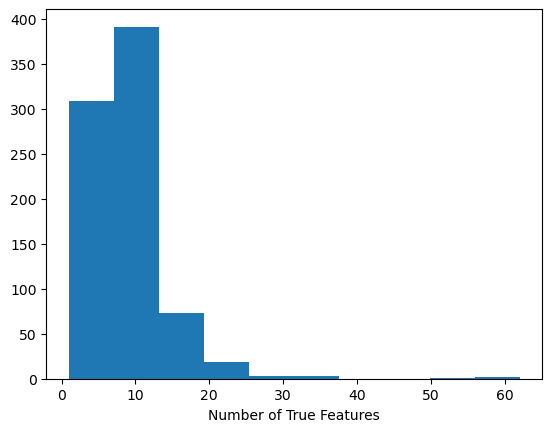

In [128]:
sums = []
for row in train_data_reduced:
    sums.append(sum(row))
plt.hist(sums)
plt.xlabel('Number of True Features')
plt.show()

#### The histogram shows that most observations have very few True labels in the features. Out of 100 features, the average number of observations have 10 features labeled as True.

/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


<Axes: >

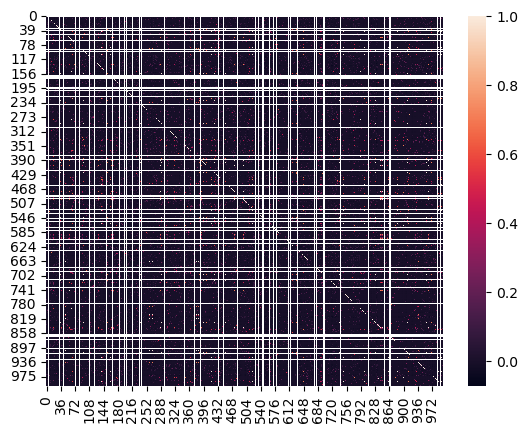

In [129]:
corr_data = np.corrcoef(train_data_reduced, rowvar = False)
sns.heatmap(corr_data)

#### After some initial EDA, it is confirmed that the dataset is very sparse. Each observation has very few positive features. Because the data is binary, the heatmap showing feature correlations isn't super helpful here, though it shows that most features are uncorrelated with each other, reducing risk of bias introduced by the feature reduction and selection process.

## Model Selection

#### The score of the basic logistic regression model is pretty good, but only uses a small subset of the total features. This could be introducing bias, reducing the efficacy of the model. Because SVM can handle datasets with large numbers of features, a SVM model reintroducing some of the features that were removed previously will be tested for fit, along with an AdaBoost model and a SVM model with a nonlinear kernel.

/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost score: 0.8657142857142858


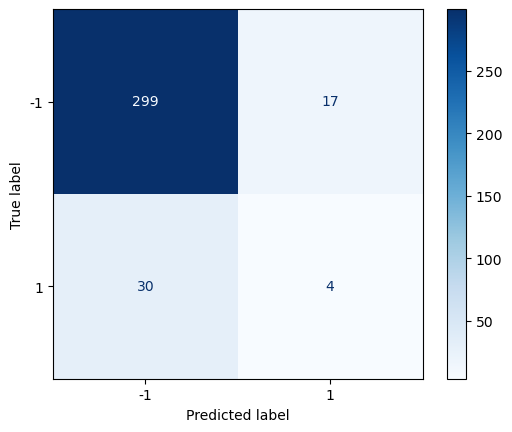

In [119]:
est = DecisionTreeClassifier(max_depth = 1)
adab = AdaBoostClassifier(est, n_estimators = 75).fit(train_data_reduced, train_labels)
print('AdaBoost score:', adab.score(test_data_reduced, test_labels))
ypred = adab.predict(test_data_reduced)
cm = confusion_matrix(test_labels, ypred)
disp = ConfusionMatrixDisplay.from_predictions(test_labels, ypred, cmap = 'Blues') 

SVM score with reduced features: 0.8485714285714285


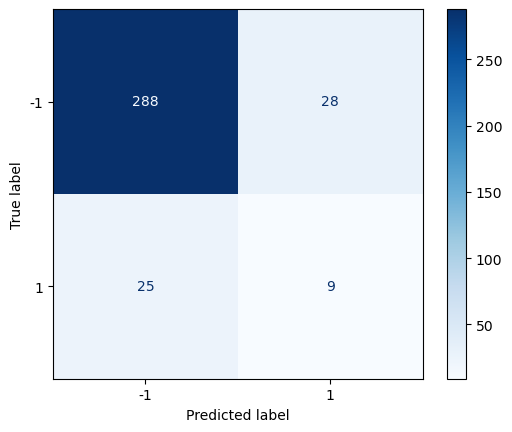

In [116]:
svm_reduced_feats = LinearSVC(dual = 'auto').fit(train_data_reduced, train_labels)
print('SVM score with reduced features:', svm_reduced_feats.score(test_data_reduced, test_labels))
ypred = svm_reduced_feats.predict(test_data_reduced)
cm = confusion_matrix(test_labels, ypred)
disp = ConfusionMatrixDisplay.from_predictions(test_labels, ypred, cmap = 'Blues') 

SVM score with all features: 0.9314285714285714


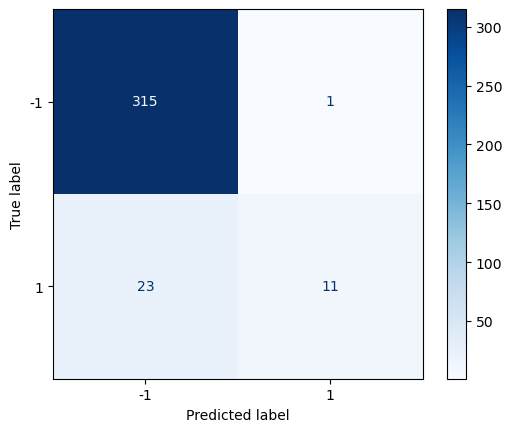

In [117]:
svm_all_feats = LinearSVC(dual = 'auto').fit(train_data, train_labels)
print('SVM score with all features:', svm_all_feats.score(test_data, test_labels))
ypred = svm_all_feats.predict(test_data)
cm = confusion_matrix(test_labels, ypred)
disp = ConfusionMatrixDisplay.from_predictions(test_labels, ypred, cmap = 'Blues') 

Nonlinear SVM score with all features: 0.9028571428571428


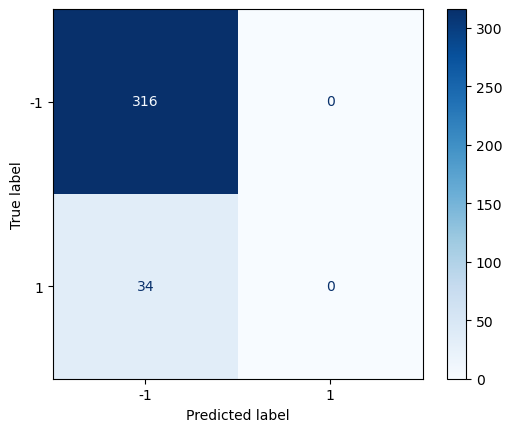

In [120]:
svm_nonlin = SVC(kernel = 'rbf').fit(train_data, train_labels)
print('Nonlinear SVM score with all features:', svm_nonlin.score(test_data, test_labels))
ypred = svm_nonlin.predict(test_data)
cm = confusion_matrix(test_labels, ypred)
disp = ConfusionMatrixDisplay.from_predictions(test_labels, ypred, cmap = 'Blues')

#### After testing several models, moving forward the linear SVM model with all features will be used. That model had the best accuracy and the confusion matrix showed the most true positives predicted. To further improve the model, hyperparameter tuning will be done to determine the best C value and which loss mode to gain the best accuracy with the most balanced bias and variance.

In [130]:
est = LinearSVC(dual = 'auto')
C = [2**i for i in range(-20,5)]
param_grid = {'C': C}
grid = GridSearchCV(est, param_grid, cv = 2).fit(train_data, train_labels)

In [131]:
C = grid.best_params_['C']
print(C)

0.015625


#### Try hinge vs squared hinge loss

In [108]:
svm_hinge = LinearSVC(dual = 'auto', C = C, loss = 'hinge').fit(train_data, train_labels)
print('SVM model with hinge loss score:', svm_hinge.score(test_data, test_labels))

SVM model with hinge loss score: 0.9314285714285714


In [109]:
svm_sq_hinge = LinearSVC(dual = 'auto', C = C, loss = 'squared_hinge').fit(train_data, train_labels)
print('SVM model with hinge loss score:', svm_hinge.score(test_data, test_labels))

SVM model with hinge loss score: 0.9314285714285714


## Final Model

In [110]:
final_model = LinearSVC(dual = 'auto', C=C, loss = 'hinge').fit(train_data, train_labels)
print(final_model.score(test_data, test_labels))

0.9314285714285714


### Evaluating Model Performance

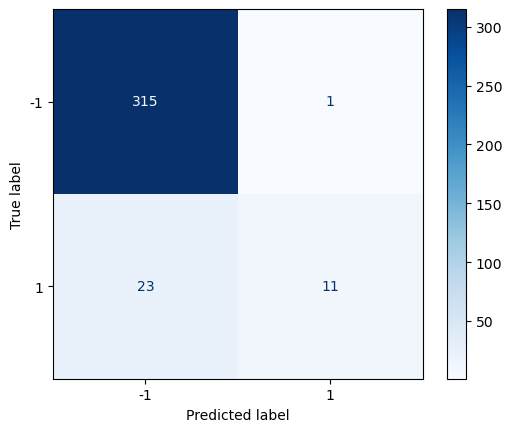

In [121]:
ypred = final_model.predict(test_data)
cm = confusion_matrix(test_labels, ypred)
disp = ConfusionMatrixDisplay.from_predictions(test_labels, ypred, cmap = 'Blues') 

#### This confusion matrix shows that this model is very good at recognizing negative values, biologics that won't bind to the receptor, but not very good at recognizing positives, biologics that will bind to the receptor. This is likely due to the sparse character of the data; because there are very few positives to begin with, the model is better at recognizing negatives, which are the majority of the data.

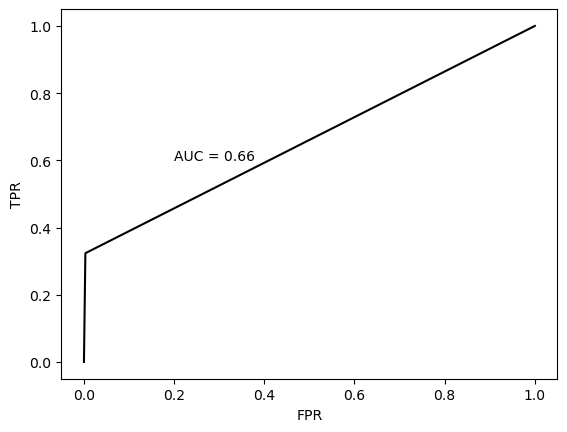

In [122]:
fpr, tpr, th = roc_curve(test_labels, ypred)
auc = roc_auc_score(test_labels, ypred)
auc = round(auc,3)
plt.plot(fpr,tpr, 'k-')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.text(0.2,0.6, f'AUC = {auc}')
plt.show()

#### The ROC curve is not the best metric for this dataset because there are so few positives. Out of 350 observations, only 34 are true positives. This creates bias and skews the ROC curve. It is still a good visualization to further enforce the idea that the model is better at recognizing negative values than positive ones.

## Discussion and Conclusions

#### The final model predicted binding of small molecule drugs with an accuracy of 0.93. The confusion matrix showed that the model is better at predicting true negatives than true positives. Additionally, as expected, the SVM algorithm worked the best for modeling this sparse dataset and was able to handle all features. 

#### One key takeaway from this project was that parameter tuning for the SVC model didn't make much difference in the prediction power of the model. Both parameters tested in the tuning process, C and loss, did not have much impact on model performance. It's possible that with better feature selection the parameter tuning could have made a bigger difference. This could also be due to the intrinsic bias of the model- with such a sparse dataset, it's possible that the power of changing C and loss did not have as strong of an impact as it would with a less sparse dataset.

#### There are many ways to have made this model better. Due to constraints in time and computing power, the feature selection was not able to be tuned properly for the final model and all features were used. It's possible that proper feature selection could have improved the final model. Additionally, the final model did not predict positive values as well as negative values. It's possible that with better parameter tuning or other changes to reduce bias that this could have been improved.